# Lab1886 Task
***

In this task we are looking at a bicycle sharing system in Seattle. The [data](https://www.kaggle.com/pronto/cycle-share-dataset) provided by Pronto Cycle Share via kaggle provides data on individual trips, stations, and daily weather over a time span of approximately 2 years. 

**Goal.** We aim to predict the damand of bikes at a certain day, time, and station using a machine learning algorithm. 

## Setting up

Before taking a first look at the data, I want to briefly comment on how I set up. I decided to use what I am most familiar with. In the context of ML, I therefore prefer to use *Anaconda* as a *Python* distribution, because it resolves issues connected to interdependencies and version compatibility between packages on its own. I choose *Keras* with *TensorFlow* as a backend as my framework as I am most familiar with them. For the most part I rely on *Pandas* and *pyplot* for data manipulation and visualization. 

I also set up a git repository on [bitbucket](https://bitbucket.org) for version control. On a general note, my preferred IDE for Python is PyCharm.

We use some standard built-in *magic* commands for jupyter notebooks

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import a few basic libraries ...

In [2]:
import os
import folium
import pandas as pd
import pandas_summary as pdsm
import seaborn as sns

from IPython.core.display import display, HTML

and set the path variable for our dataset

In [3]:
PATH = 'dataset/'

## Creating DataFrames

The first step is to read-in the data. Each table is called by its file name. When I first ran the command 
I got a `ParseError` telling me that line 50794 exceeds the expected number of columns. Looking at it I saw the the head of the table as well as some other lines were repeated.

In [4]:
with open(f'{PATH}trip.csv', 'r') as file:
    for y in [x for i,x in enumerate(file) if i in [1, 2, 50793, 50793*2]]:
        print(y)

431,"10/13/2014 10:31","10/13/2014 10:48","SEA00298",985.935,"2nd Ave & Spring St","Occidental Park / Occidental Ave S & S Washington St","CBD-06","PS-04","Member","Male",1960

432,"10/13/2014 10:32","10/13/2014 10:48","SEA00195",926.375,"2nd Ave & Spring St","Occidental Park / Occidental Ave S & S Washington St","CBD-06","PS-04","Member","Male",1970

59000,"4/17/2015 14:21","4/17/2015 19:21","SEA00362",17990.668,"6th Ave S & S King St","Westlake Ave & 6th Ave","ID-04","SLU-15"trip_id","starttime","stoptime","bikeid","tripduration","from_station_name","to_station_name","from_station_id","to_station_id","usertype","gender","birthyear"

59000,"4/17/2015 14:21","4/17/2015 19:21","SEA00362",17990.668,"6th Ave S & S King St","Westlake Ave & 6th Ave","ID-04","SLU-15","Short-Term Pass Holder",,



I first deleted the repeated header in line 50794 and wrote to a new file *new_trip.csv*, so that I won't do changes on the initial data set, 

In [5]:
with open (f'{PATH}new_trip.csv', 'w') as new_file:
    with open(f'{PATH}trip.csv', 'r') as file:
        for i,line in enumerate(file):
            if i == 50793:
                new_file.write(line.split('trip_id',1)[0] + '\n')
            else: 
                new_file.write(line)

and transfered the data into panda `DataFrames`. Note that I chose *new_trip*.

In [6]:
table_names = ['station', 'new_trip', 'weather']
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

To check for duplicates I looked at the summary, particularly for the trip_id, as this column should only have unique values.

In [7]:
pdsm.DataFrameSummary(tables[1][['trip_id']]).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
trip_id,286858,112432,76565.1,431,43051,103486,179545,255245,286858,236065,0,0%,numeric


This made me realize that the first 50793 lines were simply repeated as 
>`trip_id.counts - trip_id.uniques = 50793`.

Therefore I deleted the first entries in the *new_trip* table

In [8]:
tables[1].drop(tables[1].index[:50793], inplace=True)

reindexed the DataFrame

In [19]:
tables[1]=tables[1].reset_index(drop=True)

and as a quick check looked if the dimensions mathed up.

In [20]:
tables[1].shape

(236065, 12)

In [21]:
tables[1].head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


Saving what we have done so far.

In [11]:
for i,table in enumerate(tables):
    table.to_pickle(f'tmp/df{i}.pickle')

Reloading DataFrames from saved ones.

In [12]:
# Loading preprocessed tables into DataFrames
table_names = ['station', 'new_trip', 'weather']
tables = [pd.read_pickle(f'tmp/df{i}.pickle') for i in range(len(table_names))]
station, new_trip, _ = tables

## First look at the data

Now leat us have a look at the first few lines of each table:

In [13]:
for table in tables: display(table.head(2).T)

,0,1
station_id,BT-01,BT-03
name,3rd Ave & Broad St,2nd Ave & Vine St
lat,47.6184,47.6158
long,-122.351,-122.349
install_date,10/13/2014,10/13/2014
install_dockcount,18,16
modification_date,NaN,NaN
current_dockcount,18,16
decommission_date,NaN,NaN


,50793,50794
trip_id,431,432
starttime,10/13/2014 10:31,10/13/2014 10:32
stoptime,10/13/2014 10:48,10/13/2014 10:48
bikeid,SEA00298,SEA00195
tripduration,985.935,926.375
from_station_name,2nd Ave & Spring St,2nd Ave & Spring St
to_station_name,Occidental Park / Occidental Ave S & S Washing...,Occidental Park / Occidental Ave S & S Washing...
from_station_id,CBD-06,CBD-06
to_station_id,PS-04,PS-04
usertype,Member,Member


,0,1
Date,10/13/2014,10/14/2014
Max_Temperature_F,71,63
Mean_Temperature_F,62,59
Min_TemperatureF,54,55
Max_Dew_Point_F,55,52
MeanDew_Point_F,51,51
Min_Dewpoint_F,46,50
Max_Humidity,87,88
Mean_Humidity,68,78
Min_Humidity,46,63


Here is a Summary by calling `pandas_summary.DataFrameSummary()` for all tables like we did before when looking at the *trip_id* column

In [8]:
for table in tables: display(pdsm.DataFrameSummary(table).summary().T)

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,58,0,0%,unique
name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,58,0,0%,unique
lat,58,47.6248,0.0190658,47.5985,47.6132,47.6186,47.6277,47.6661,58,58,0,0%,numeric
long,58,-122.327,0.0149567,-122.355,-122.339,-122.328,-122.317,-122.284,58,58,0,0%,numeric
install_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,9,0,0%,categorical
install_dockcount,58,17.5862,3.06099,12,16,18,18,30,58,7,0,0%,numeric
modification_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,12,41,70.69%,categorical
current_dockcount,58,16.5172,5.11702,0,16,18,18,26,58,7,0,0%,numeric
decommission_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,54,93.10%,unique


,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
trip_id,236065,130060,72842.3,431,67746,130526,192900,255245,236065,236065,0,0%,numeric
starttime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,176216,0,0%,categorical
stoptime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,169285,0,0%,categorical
bikeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,493,0,0%,categorical
tripduration,236065,1202.61,2066.42,60.008,392.265,633.235,1145.02,28794.4,236065,218883,0,0%,numeric
from_station_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
to_station_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
from_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
to_station_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,61,0,0%,categorical
usertype,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,236065,2,0,0%,bool


,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,689,689,0,0%,unique
Max_Temperature_F,689,64.0276,12.4278,39,55,63,73,98,689,45,0,0%,numeric
Mean_Temperature_F,688,56.5843,10.4081,33,48,56,65,83,688,47,1,0.15%,numeric
Min_TemperatureF,689,49.4543,9.45144,23,43,50,57,70,689,37,0,0%,numeric
Max_Dew_Point_F,689,48.5718,7.50123,10,44,50,54,77,689,44,0,0%,numeric
MeanDew_Point_F,689,45.0218,7.91403,4,41,46,51,59,689,43,0,0%,numeric
Min_Dewpoint_F,689,40.8737,8.85461,1,36,42,47,57,689,48,0,0%,numeric
Max_Humidity,689,84.5414,9.71895,40,78,86,90,100,689,43,0,0%,numeric
Mean_Humidity,689,68.5065,12.7019,24,60,70,79,95,689,64,0,0%,numeric
Min_Humidity,689,49.9739,15.8257,15,38,50,63,87,689,70,0,0%,numeric


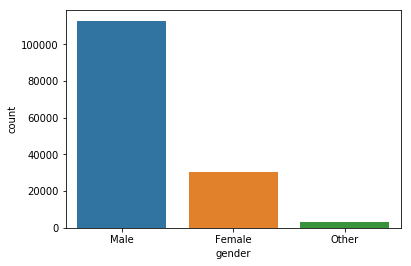

In [11]:
for i, table in enumerate(tables):
    locals()['df' + str(i)] = table
    
#select categorical variables only
df1_cat = df1.select_dtypes(include = 'object').copy()
#get counts of each variable value
df1_cat.gender.value_counts()
#count plot for one variable
_ = sns.countplot(data = df1_cat, x = 'gender')

In [53]:
data = station[['station_id', 'lat', 'long']]

In [87]:
# Setting up an empty map
flm_map = folium.Map(location=[47.635, -122.31], zoom_start=12)

# adding marker for stations positions in Seattle with ID as label
for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lat'], data.iloc[i]['long']], popup=data.iloc[i]['station_id']).add_to(flm_map)
flm_map

## Data Cleaning and Feature Engineering
Since we are handling tabular data, we have to do all the necessary cleaning and feature engineering steps although we are using a Neural Network.

## Prediction Model